In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle
from astropy import units as u
import xml.etree.ElementTree as ET
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, LSR,HeliocentricMeanEcliptic
from matplotlib.gridspec import GridSpec
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import trapz
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from astropy.visualization.wcsaxes import SphericalCircle
import scipy as sp
from imp import reload
import glob

In [30]:
import sys,os
sys.path.append('../')
import Gaussian_fitting as Gf
#
import spectra_decomposing as sd
import read_GASKAP_data as rd

In [31]:
datapathbase='/d/bip5/hchen' 

# original data

In [29]:
fit = fits.open(datapathbase+'/GASKAP_data/NHI_moment1_LMC.fits')
NHI_total_LMC=fit[0].data
#TB_max=np.max(TB,axis=0)
Moment1_LMC=fit[1].data

In [31]:
name_outskirts=np.array(['J043855-672153', 'J044047-695217', 'J044056-662423',
       'J044056-662425', 'J044809-703144', 'J044902-705148',
       'J044902-705155', 'J044903-705212', 'J045421-680056',
       'J045545-694830', 'J045608-701434', 'J045608-701435',
       'J045954-710737', 'J050200-693150', 'J050200-693158',
       'J050201-693151', 'J050202-693154', 'J051819-661717',
       'J052229-703757', 'J052340-705019', 'J052341-705122',
       'J053544-660227', 'J054150-733215', 'J054623-665544'])

In [23]:
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_absorption_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[s['comp_name']=='J044056-662423']

src_id,sbid,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
,,,,deg,deg,,mJy.beam-1,mJy.beam-1,,,,,,arcsec,arcsec,deg,km / s,km / s,chan,,,,,,km / s,km / s
int64,int64,str32,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
0,0,J044056-662423,J044056-662423_233,70.236046,-66.406409,A,379.98699951171875,0.002101641117095402,0.008241374273762698,0.3330494328550403,7.265373057076351,1.0402945433382347,137.0,5.025000095367432,4.804999828338623,76.27999877929688,233.65693550160026,227.79383165472504,7,0.7072451104831944,0.00847309824482025,0.34637798224508026,0.011909229528225429,34.55110292103266,1.28482404244293,0.02199960343301062


(375,)
(222,)


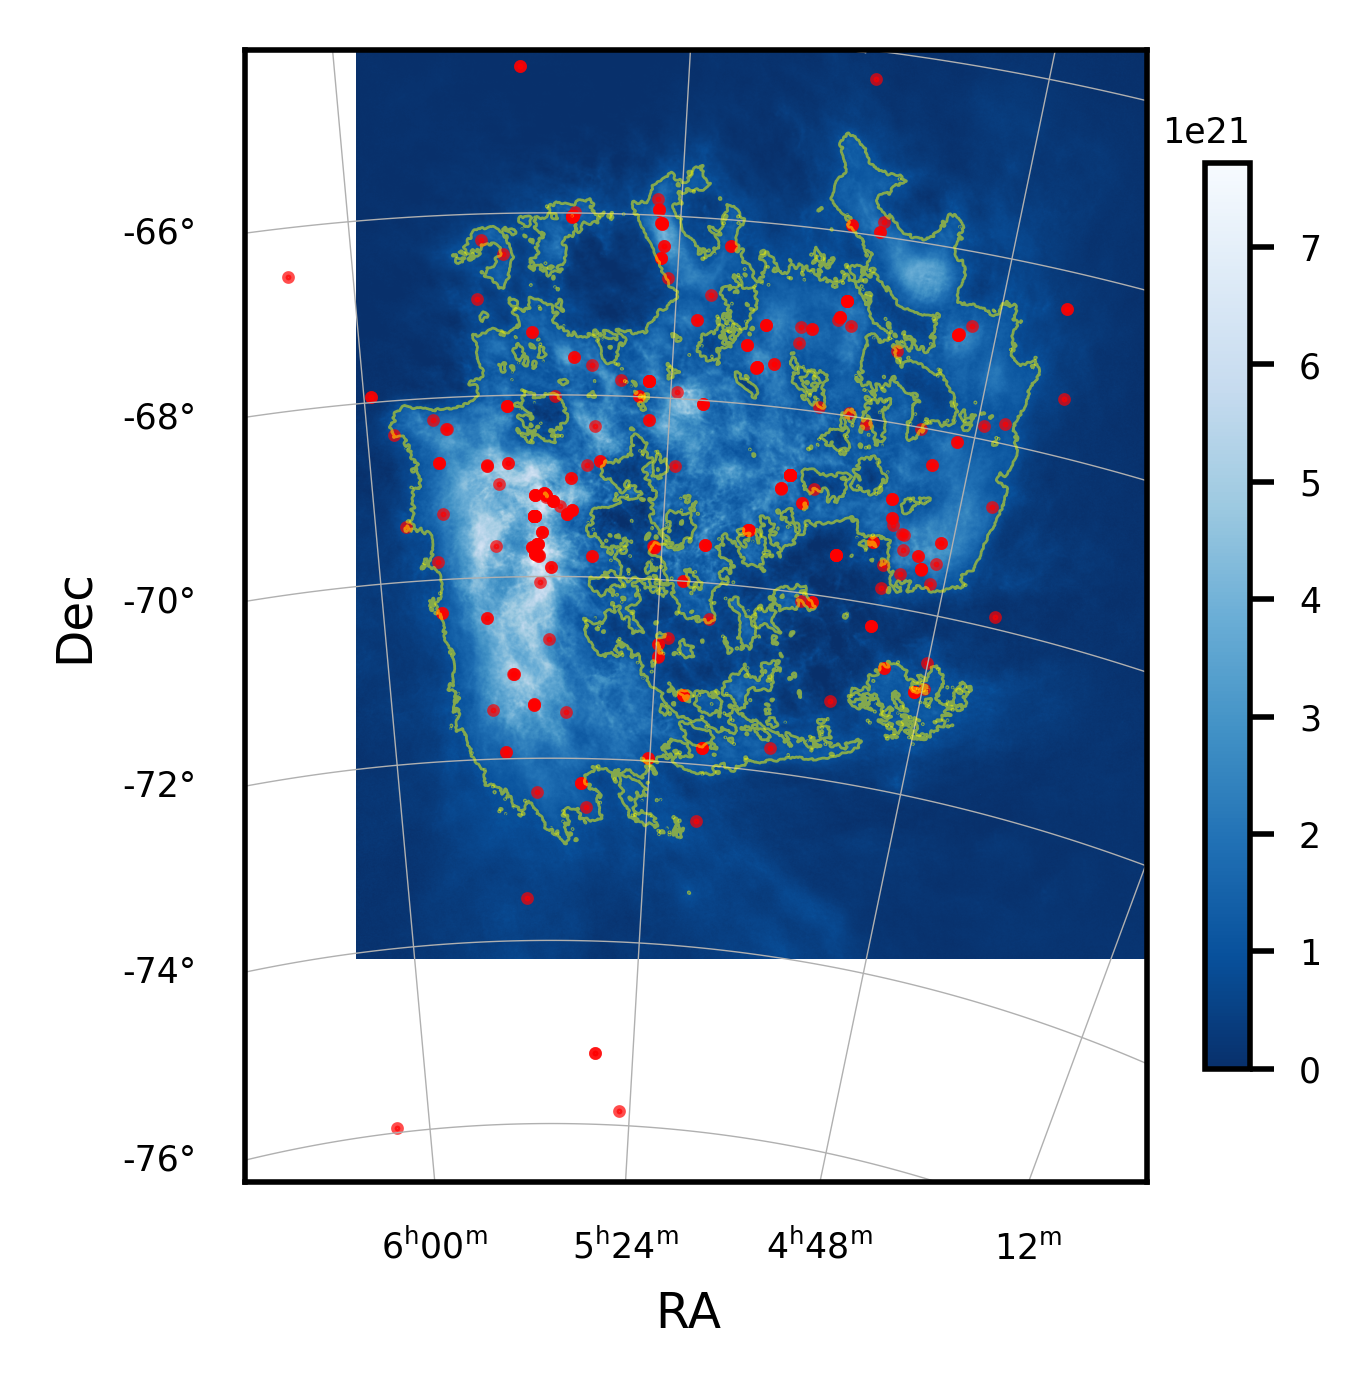

In [30]:
a=parse(datapathbase+'/LMC_abs_new/gaskap_phase2_lmc_absorption_v0.2.vot')
info1=a.get_first_table().to_table(use_names_over_ids=True)
na_=np.array(info1['comp_name'])
print(np.unique(na_).shape)
_ra=np.array(info1['ra'])
_dec=np.array(info1['dec'])
vpeak_LMC_all=(np.array(info1['start_vel'])+np.array(info1['end_vel']))/2
#Ts_LMC_all=np.array(info1['start_vel'])
p=np.argwhere((vpeak_LMC_all>145.85)&(vpeak_LMC_all<316.55)).flatten()
na_,_ra,_dec=na_[p],_ra[p],_dec[p]
name_LMC_all=np.unique(na_)
print(name_LMC_all.shape)




# Define the figure and the grid layout
fig = plt.figure(figsize=(6, 3), dpi=500)
grid = plt.GridSpec(1, 2, width_ratios=[1.2, 1])  # Adjust width ratios to make left plot larger

lmc_wcs = wcs.WCS(fit[0].header)
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)


# Right plot
#x1, x2, y1, y2 = 220, -250, 320, -220
x1, x2, y1, y2 = 1, -1, 1, -1
lmc_wcs_cut = lmc_wcs[x1:x2, y1:y2]
datacuthi = NHI_total_LMC[x1:x2, y1:y2]
ax2 = fig.add_subplot(grid[0, 0], projection=lmc_wcs_cut, slices=('x', 'y'))
ax2.set_xlabel('RA ', fontsize=7)
ax2.set_ylabel('Dec', fontsize=7)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_ticks(spacing=9 * u.deg, color='white',)
lat.set_ticks(spacing=2 * u.deg, color='white')
ax2.coords.grid(linewidth=0.2, linestyle='solid')

plt.imshow(datacuthi, origin='lower', cmap='Blues_r', vmin=1e-12, alpha=1)
plt.colorbar(shrink=0.8)

y=np.nan_to_num(datacuthi,nan=0)
sigma = [3,3]
y = sp.ndimage.filters.gaussian_filter(y, sigma, mode='constant')
contour_levels = [1e21]
ax2.contour(y, levels=contour_levels, colors='yellow', linewidths=0.4,alpha=0.5)

#new_data=CNMonlydata.drop_duplicates
ax2.scatter(_ra, _dec, s=0.7,
           transform=ax2.get_transform('world'), c='r', label='selected points',alpha=0.7)



(421,)


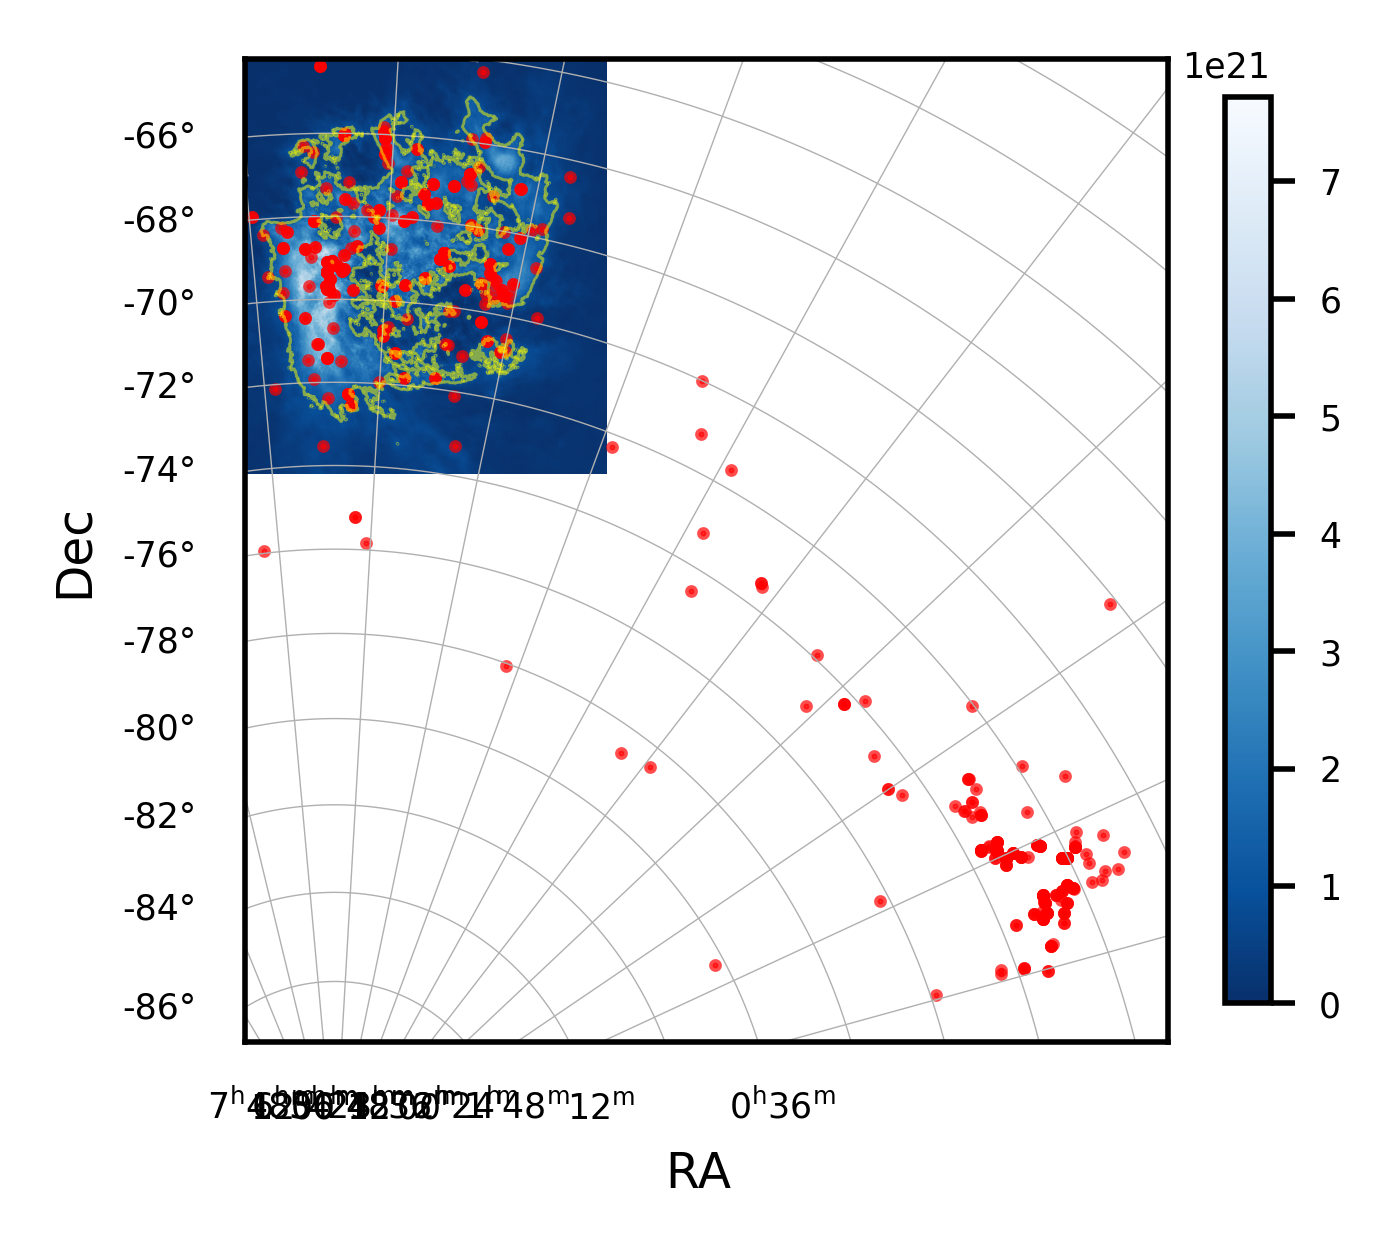

In [32]:
f=['M355+07','M000+07','M355+02','M000+02','M000-02']
sb=['sb38373','sb38791','sb38814','sb33047','sb38845']
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_absorption_mag_v1.0.vot')
info1=a.get_first_table().to_table(use_names_over_ids=True)
na_=np.array(info1['comp_name'])
#field=np.array(info1['field'])
_ra=np.array(info1['ra'])
_dec=np.array(info1['dec'])
print(np.unique(na_).shape)

vpeak_LMC_all=(np.array(info1['start_vel'])+np.array(info1['end_vel']))/2
#Ts_LMC_all=np.array(info1['start_vel'])
p=np.argwhere((vpeak_LMC_all>145.85)&(vpeak_LMC_all<316.55)).flatten()
na_=na_[p]
_ra,_dec=_ra[p],_dec[p]
name_LMC_all=np.unique(na_)
name_LMC_all.shape


# Define the figure and the grid layout
fig = plt.figure(figsize=(6, 3), dpi=500)
grid = plt.GridSpec(1, 2, width_ratios=[1.2, 1])  # Adjust width ratios to make left plot larger

lmc_wcs = wcs.WCS(fit[0].header)
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)


# Right plot
#x1, x2, y1, y2 = 220, -250, 320, -220
x1, x2, y1, y2 = 1, -1, 1, -1
lmc_wcs_cut = lmc_wcs[x1:x2, y1:y2]
datacuthi = NHI_total_LMC[x1:x2, y1:y2]
ax2 = fig.add_subplot(grid[0, 0], projection=lmc_wcs_cut, slices=('x', 'y'))
ax2.set_xlabel('RA ', fontsize=7)
ax2.set_ylabel('Dec', fontsize=7)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_ticks(spacing=9 * u.deg, color='white',)
lat.set_ticks(spacing=2 * u.deg, color='white')
ax2.coords.grid(linewidth=0.2, linestyle='solid')

plt.imshow(datacuthi, origin='lower', cmap='Blues_r', vmin=1e-12, alpha=1)
plt.colorbar(shrink=0.8)

y=np.nan_to_num(datacuthi,nan=0)
sigma = [3,3]
y = sp.ndimage.filters.gaussian_filter(y, sigma, mode='constant')
contour_levels = [1e21]
ax2.contour(y, levels=contour_levels, colors='yellow', linewidths=0.4,alpha=0.5)

#new_data=CNMonlydata.drop_duplicates
ax2.scatter(_ra, _dec, s=0.7,
           transform=ax2.get_transform('world'), c='r', label='selected points',alpha=0.7)



In [53]:
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_absorption_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[s['comp_name']=='J003524-732222']

src_id,sbid,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
,,,,deg,deg,,mJy.beam-1,mJy.beam-1,,,,,,arcsec,arcsec,deg,km / s,km / s,chan,,,,,,km / s,km / s
int64,int64,str32,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
0,0,J003524-732222,J003524-732222_161,8.851776,-73.372828,B,24.26099967956543,8.728479650283301e-05,0.10047787489725746,0.9765353890608073,2.2623770788523143,1.2993324699928148,73.0,5.364999771118164,5.175000190734863,20.610000610351562,161.20021451120695,158.26868268057535,4,0.3227970809320076,0.10047787489725746,1.1307313855887937,0.2709980882662484,6.7398212766786605,2.6098512875523694,0.2069497869135975


In [55]:
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_abs_spectra_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[s['comp_name']=='J003524-732222']

id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids
,,,deg,deg,,,,mJy.beam-1,,mJy.beam-1,,,,,,,km / s,,,,arcsec,arcsec,deg,1 / cm2,,,,
int64,str32,str32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,str7,object
0,J003524-732222,SB30665_component_182a,8.851776,-73.372828,304.517195173216,-43.70604523121019,B,24.26099967956543,28.36199951171875,8.728479650283301e-05,0.10047787489725746,0.9765353890608073,2.2623770788523143,1.2993324699928148,73.0,0.3227970809320076,160.22303723432972,1.1307313855887937,0.2709980882662484,True,5.364999771118164,5.175000190734863,20.610000610351562,0.0,False,0.005397538287016373,M344-11,"10944,30665"


# select only LMC source

In [7]:
f=['M355+07','M000+07','M355+02','M000+02','M000-02']
sb=['sb38373','sb38791','sb38814','sb33047','sb38845']

#have field not in LMC
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_absorption_mag_v1.0.vot')
info1=a.get_first_table().to_table(use_names_over_ids=True)
na_=np.array(info1['comp_name'])
print(np.unique(na_).shape)

vpeak_LMC_all=(np.array(info1['start_vel'])+np.array(info1['end_vel']))/2
p=np.argwhere((vpeak_LMC_all>145.85)&(vpeak_LMC_all<316.55)).flatten()
na_=np.unique(na_[p])
print(na_.shape)

a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_abs_spectra_mag_v1.0.vot')
info1=a.get_first_table().to_table(use_names_over_ids=True)
na_2=np.array(info1['comp_name'])
field=np.array(info1['field'])
p=np.isin(na_2,na_)
field_=field[p]
na_2=na_2[p]
#only select field in the LMC
p=np.isin(field_,f)
field_=field_[p]
na_2=na_2[p]
print(np.unique(na_2).shape,na_2.shape)
np.savetxt('LMC_source_name.txt',na_2,fmt='%s')

(421,)
(344,)
(205,) (205,)


# generate emission spectra for LMC sources

In [32]:
from tqdm import tqdm
import read_data as rd_emi
name_abs=np.loadtxt('LMC_source_name.txt',dtype=str)
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_abs_spectra_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s=s[np.isin(s['comp_name'],name_abs)]
ra=np.array(s['ra'])
dec=np.array(s['dec'])
name=np.array(s['comp_name'])

#a=glob.glob('/d/bip5/hchen/LMC_GASKAP_emi_all/*.txt')
#b=np.array([filename[-18:-4] for filename in a])
#np.isin(name,b).shape

In [41]:

for i in tqdm(range(len(ra)), desc="Processing"):
#for i in [0,1,2,3,4,5]:
    x,y,yer=rd_emi.read(ra[i],dec[i],filep='/d/bip5/hchen/GASKAP_data/LMC_new.fits',avg_mode='base',spec='no',smooth=False)
    data = np.column_stack((x,y,yer))
    if np.mean(y)==0.:
        print('no emi')
       # with open('no_emi.txt', 'a') as file:
       #     file.write(str(i))
        np.savetxt('no_emi.txt', [name[i]], fmt='%s', delimiter='\t')
    np.savetxt('/d/bip5/hchen/LMC_GASKAP_emi_all_abs/%s.txt'%(name[i]), data, fmt='%f', delimiter='\t')
    #np.savetxt('/d/bip5/hchen/LMC_GASKAP_emi_all/%s.txt'%(name[i]), data, fmt='%f', delimiter='\t')

Processing: 100%|██████████| 205/205 [08:23<00:00,  2.46s/it]


# Read & plot

In [42]:
#print sources observed twice
nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
nabs_n=glob.glob(datapathbase+'/LMC_abs_new/abs_v1.0/sb*')
nabs=[None] * len(nemi)
for i, ni in enumerate(nemi):
    na_=ni[-18:-4]
    for nj in nabs_n:
        _=glob.glob(nj+'/averaged/spectra/*_spec.vot')
        _all=[filename[-23:-9] for filename in _]
        if na_ in _all:
            if nabs[i] is not None:
                print(i,nj,na_)
                break  # Exit the loop once a match is found for this `na_`
            else:
                nabs[i] = f'{nj}/averaged/spectra/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                
nemi,nabs=np.array(nemi),np.array(nabs)  
nlist=[filename[-18:-4] for filename in nemi]
nlist=np.array(nlist)        
nabs=np.array(nabs)  
# saturated     J050543-665813 3 detections but 2 have none detections, one have saturated spectra      need to exclude
#J050946-670557 just random noise
#J051222-673218 duplicate J051222-673220
exclude_name=['J050543-665813','J050946-670557','J051222-673218'] 
#choose high S/N
#p=np.argwhere(nlist=='J051537-672127').flatten()
#nabs[p]='/d/bip5/hchen/LMC_abs_new/sb38791/spectra_abs/J051537-672127_spec.vot'
#p=np.argwhere(nlist=='J053254-723155').flatten()
#nabs[p]='/d/bip5/hchen/LMC_abs_new/sb38845/spectra_abs/J053254-723155_spec.vot'


In [120]:
p=np.argwhere(nlist=='J050500-664520').flatten()
nabs[p]

array(['/d/bip5/hchen/LMC_abs_new/sb38373/spectra_abs/J050500-664520_spec.vot'],
      dtype='<U69')

In [46]:
#a=parse(datapathbase+'/LMC_abs_new/gaskap_phase2_lmc_abs_spectra_v0.2.vot')
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_abs_spectra_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
Ra_all_=np.array(s['ra'])
Dec_all_=np.array(s['dec'])
name=np.array(s['comp_name'])

unique_names, indices = np.unique(name, return_index=True)
valid_indices = indices[np.isin(unique_names, nlist)]

# Now, map these indices to Ra and Dec
Ra_all = Ra_all_[valid_indices]
Dec_all = Dec_all_[valid_indices]



In [15]:
a=parse(datapathbase+'/LMC_abs_new/gaskap_phase2_lmc_abs_spectra_v0.2.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[s['comp_name']=='J043855-672153']

id,sbid,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope
,,,,deg,deg,,,,mJy.beam-1,,mJy.beam-1,,,,,,,km / s,,,,,arcsec,arcsec,deg,1 / cm2,,
int64,int64,str32,str32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,bool,float64
7,38814,J043855-672153,SB38814_component_5a,69.732885,-67.364907,278.979423285331,-37.44837101730975,A,383.14300537109375,479.6910095214844,0.001807289512504301,0.009218714412125803,0.14102479520501487,3.5021333093086877,1.0313239936528378,93.0,0.8902991984478229,241.08633174071852,0.11619769471986292,0.010862178600753405,True,True,5.710000038146973,4.135000228881836,59.75,4.1413977627798634e+20,False,-0.0002235106384265656


In [84]:
a=parse(datapathbase+'/LMC_abs_new/gaskap_phase2_lmc_absorption_v0.2.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[s['comp_name']=='J050946-670557']

src_id,sbid,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
,,,,deg,deg,,mJy.beam-1,mJy.beam-1,,,,,,arcsec,arcsec,deg,km / s,km / s,chan,,,,,,km / s,km / s
int64,int64,str32,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
298,38814,J050946-670557,J050946-670557_167,77.442899,-67.099273,C,26.35099983215332,9.34469857505067e-05,0.2542763617322734,2.086995798363357,1.2866925351880576,1.9126700534716716,59.0,7.675000190734863,4.335000038146973,76.0199966430664,167.64996684081106,166.67278430631546,2,0.08406485181133996,0.2542763617322734,2.4761667326394527,1.392466347455768,3.602124640878119,3.744766275209196,0.4054752571162048


# exclude duplicate

In [47]:


def calculate_distance_matrix(ra_list, dec_list):
    """
    Calculate the angular distance matrix for lists of RA and Dec.

    Parameters:
    ra_list : list or array of Right Ascension in degrees
    dec_list : list or array of Declination in degrees

    Returns:
    dist_matrix : A 2D numpy array containing angular distances in degrees
                  between each pair of coordinates.
    """
    # Create an array of SkyCoord objects from the RA and Dec lists
    coords = SkyCoord(ra=ra_list*u.degree, dec=dec_list*u.degree, frame='icrs')
    
    # Initialize a matrix to hold the distances
    n = len(ra_list)
    dist_matrix = np.zeros((n, n))
    
    # Calculate the separation between each pair of coordinates
    for i in range(n):
        dist_matrix[i, :] = coords[i].separation(coords).degree

    return dist_matrix*3600




In [ ]:
ra_ =Ra_all
dec_ = Dec_all
distance_matrix = calculate_distance_matrix(ra_, dec_)
po=np.argwhere((distance_matrix<15)&(distance_matrix>0))
po=np.sort(po, axis=1)
dtype = [('col1', po.dtype), ('col2', po.dtype)]
structured_array = np.core.records.fromarrays(po.transpose(), dtype=dtype)
unique_rows = np.unique(structured_array)
po2= np.column_stack((unique_rows['col1'], unique_rows['col2']))
p=po2[0]
print(nlist[p[0]],nlist[p[1]],distance_matrix[p[0],p[1]],po2.shape)

#2:J045113-693133? though saperate sources
#J045205-665514 nearby? 5-10
#12,13
#exclude_name=['J050543-665813','J050946-670557','J051222-673218','J044056-662425','J044902-705148','J045113-693200','J045152-692332','J045205-665514','J045209-665524','J045608-701435'] 
exclude_name=['J044902-705148','J045113-693200','J045152-692332','J045205-665514','J045209-665524','J045608-701435'] 


J044902-705148 J044902-705155 6.969633046832457 (38, 2)


In [51]:
a=parse(datapathbase+'/LMC_abs_new/abs_v1.0/gaskap_abs_spectra_mag_v1.0.vot')
s=a.get_first_table().to_table(use_names_over_ids=True)
s[np.isin(s['comp_name'], [nlist[p[0]],nlist[p[1]]])]

id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids
,,,deg,deg,,,,mJy.beam-1,,mJy.beam-1,,,,,,,km / s,,,,arcsec,arcsec,deg,1 / cm2,,,,
int64,str32,str32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,str7,object
25,J044902-705155,SB38814_component_14b,72.258713,-70.865478,282.68102497539905,-35.40102454827674,A,67.60399627685547,116.36000061035156,0.00041847316606435925,0.028926467386237543,0.552552187087941,4.213102353065075,1.1059929672708353,114.0,0.5534407801828943,3.645939060462333,0.5916005240969349,0.07688555907816685,True,6.505000114440918,4.989999771118164,61.63999938964844,1.1538551027090478e+21,False,0.0028503734212453552,M355+02,38814
26,J044902-705148,SB38814_component_14c,72.258982,-70.863544,282.6787581684569,-35.40160257033081,A,52.70800018310547,65.81700134277344,0.0005124677760560611,0.03461601392248002,0.5322795251434261,3.9681595455244913,1.1071381706376406,104.0,0.5748586454942145,3.644620277713431,0.5536311023300039,0.08808474704505415,True,5.239999771118164,4.494999885559082,62.15999984741211,1.1538551027090478e+21,False,0.0028444790156800202,M355+02,38814


57
BIC  922.6018847216094 n=1
BIC  264.09286639076225 n= 2
BIC  243.2944164542584 n= 3
BIC  253.81952355559105 n= 4
final n= 3.0 0.08347679580101235 [False False False] [0.37373871 0.25810058 0.10610507]
BIC= 243.29446060125855
[282.99925705 268.6458677  276.73649492]
BIC= 276.40383722801255
[0.3836774  0.26176377 0.11056418] 0.07673547926646543 -0.08449278535337315


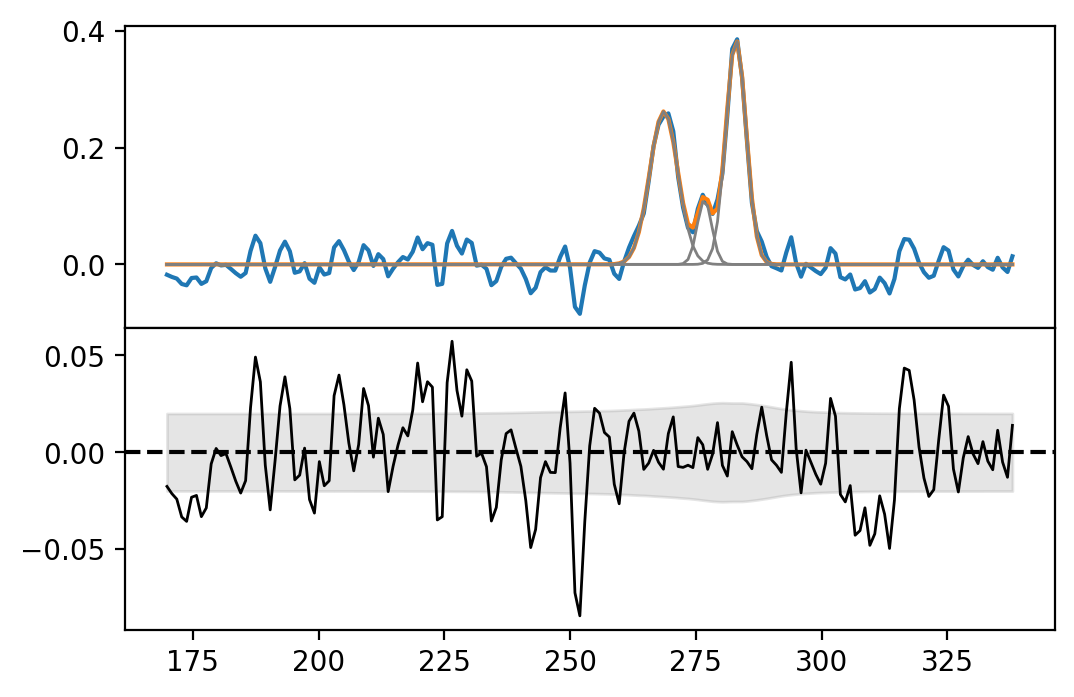

In [121]:
reload(rd)
#file_path = "/d/bip5/hchen/output_data/LMC_fitting/long_runs.txt"

# Read the file and create a list of strings (one per line)
#with open(file_path, 'r') as file:
#    lines = [line.strip() for line in file]
p=np.argwhere(np.array(nlist)=='J050500-664520').flatten()
j=p[0]
print(j)
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
reload(Gf)
#Gf.fitting_plot(x,y,yerr,x_peak=[3.12835286e+02,2.61895645e+02+10])
g = Gaussian1DKernel(stddev=0.5)
#Gf.fitting_plot(x,convolve(y, g),yerr)

popt_,pcov_=Gf.fitting(x,convolve(y, g),yerr)
print(popt_[1::3])
if y.max()>=1.:
    print('Satuated')
    p=np.argwhere(y>=0.99).flatten()
    y[p]=y[p]/y.max()*0.99
    #y=y/y.max()-np.exp(-3)
y=y
Gf.fitting_plot(x,y,yerr,x_peak=popt_[1::3])

In [88]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Define the coordinates
coord1 = SkyCoord('05h12m22s', '-67d32m18s', frame='icrs')
coord2 = SkyCoord('05h12m22s', '-67d32m20s', frame='icrs')

# Calculate the separation in arcseconds
separation = coord1.separation(coord2)
separation_arcsec = separation.arcsec  # Convert to arcseconds

print(f"The angular separation is {separation_arcsec:.2f} arcseconds.")


The angular separation is 2.00 arcseconds.


In [135]:
import numpy as np

# Example data
data = np.array([[2, 3],
                 [3, 2],
                 [9, 10],
                 [10, 9]])

# Step 1: Sort each row to ensure the smallest number is first
data_sorted = np.sort(data, axis=1)

# Step 2: Find unique rows
# Convert to a structured array to make `np.unique` work on rows
dtype = [('col1', data_sorted.dtype), ('col2', data_sorted.dtype)]
structured_array = np.core.records.fromarrays(data_sorted.transpose(), dtype=dtype)

# Use np.unique on the structured array
unique_rows = np.unique(structured_array)
result = np.column_stack((unique_rows['col1'], unique_rows['col2']))

result

array([[ 2,  3],
       [ 9, 10]])

In [136]:
data_sorted 

array([[ 2,  3],
       [ 2,  3],
       [ 9, 10],
       [ 9, 10]])